### Want to look at how many trials are in each condition, do this per session per feature
Histograms of: 
- x as number of trials
- y as number of sessions/feature
- color as the conditions

In [2]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *
from constants.decoding_constants import *
import seaborn as sns
from scripts.anova_analysis.anova_configs import *
from scripts.anova_analysis.run_anova import load_data
import scipy
import argparse
import copy
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import itertools
from tqdm import tqdm

### Load data utils

In [3]:
FEATS_PATH = "/data/patrick_res/sessions/SA/feats_at_least_3blocks.pickle"
SESSIONS_PATH = "/data/patrick_res/sessions/SA/valid_sessions.pickle"
feat_sessions = pd.read_pickle(FEATS_PATH)
valid_sess = pd.read_pickle(SESSIONS_PATH)

In [17]:
args = argparse.Namespace(
    **AnovaConfigs()._asdict()
)

def load_session(row, args, feat):
    args.feat = feat
    beh = behavioral_utils.load_behavior_from_args(row.session_name, args)
    beh["Choice"] = beh.apply(lambda x: "Chose" if x[FEATURE_TO_DIM[feat]] == feat else "Not Chose", axis=1)
    beh["FeatPreferred"] = beh["PreferredBelief"].apply(lambda x: "Preferred" if x == feat else "Not Preferred")
    beh["sess_feat"] = f"{row.session_name} {feat}"
    beh["Response_Choice"] = beh.apply(lambda x: x["Response"] + " " + x["Choice"], axis=1)
    return beh

all_res = []
for feat in tqdm(FEATURES):
    row = feat_sessions[feat_sessions.feat == feat].iloc[0]
    sessions = valid_sess[valid_sess.session_name.isin(row.sessions)]
    res = pd.concat(sessions.apply(lambda x: load_session(x, args, feat), axis=1).values)
    all_res.append(res)
all_res = pd.concat(all_res)

100%|██████████| 12/12 [00:17<00:00,  1.45s/it]


In [18]:
def per_session_feat(group, conditions):
    return group.groupby(conditions).TrialNumber.nunique().reset_index(name="num_trials")

### For choice/feedback interactions

In [19]:
grouped = all_res.groupby("sess_feat").apply(lambda x: per_session_feat(x, ["Response_Choice"])).reset_index()

In [20]:
grouped

,sess_feat,level_1,Response_Choice,num_trials
0,20180615 CIRCLE,0,Correct Chose,108
1,20180615 CIRCLE,1,Correct Not Chose,286
2,20180615 CIRCLE,2,Incorrect Chose,78
3,20180615 CIRCLE,3,Incorrect Not Chose,185
4,20180615 RIPPLE,0,Correct Chose,110
...,...,...,...,...
871,20181010 RIPPLE,3,Incorrect Not Chose,333
872,20181010 YELLOW,0,Correct Chose,198
873,20181010 YELLOW,1,Correct Not Chose,329
874,20181010 YELLOW,2,Incorrect Chose,126


<Axes: xlabel='num_trials', ylabel='Count'>

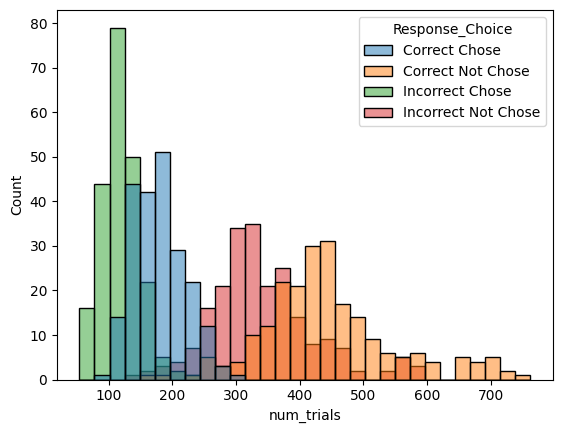

In [21]:
sns.histplot(grouped, x="num_trials", hue="Response_Choice", bins=30)

### Now for preferred/not preferred

In [22]:
sub_res = all_res[(all_res.Choice == "Chose") & (all_res.PreferredChosen)]
sub_res["Response_FeatPreferred"] = sub_res.apply(lambda x: x.Response + " " + x.FeatPreferred, axis=1)

/tmp/ipykernel_121243/1367560495.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_res["Response_FeatPreferred"] = sub_res.apply(lambda x: x.Response + " " + x.FeatPreferred, axis=1)


In [23]:
grouped = sub_res.groupby("sess_feat").apply(lambda x: per_session_feat(x, ["Response_FeatPreferred"])).reset_index()

<Axes: xlabel='num_trials', ylabel='Count'>

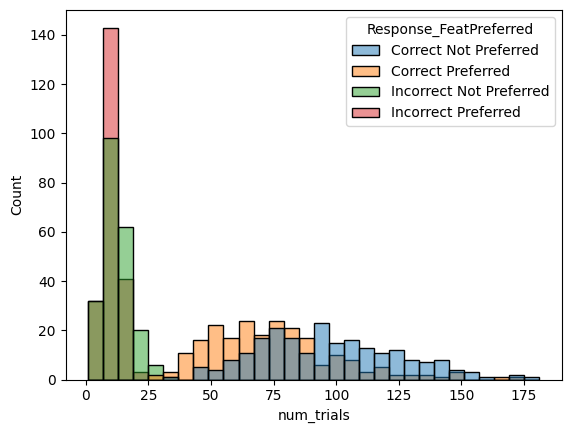

In [24]:
sns.histplot(grouped, x="num_trials", hue="Response_FeatPreferred", bins=30)